In [3]:
import pandas as pd
import numpy as np
import gensim
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
import logging
import multiprocessing
import os
from collections import namedtuple

FORMAT = '%(asctime)s %(levelname)s %(message)s'
DATEFORMAT = '%Y-%m-%d %H:%M:%S'
logging.basicConfig(level=logging.WARNING,
                    format=FORMAT,
                    datefmt=DATEFORMAT)
logger = logging.getLogger(__name__)

In [4]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
models_dir = os.path.join(parent_dir, 'models')
print('working directory: ', os.getcwd())
print('data directory:    ', data_dir, )
print('models directory:  ', models_dir)

working directory:  /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/notebooks
data directory:     /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/data
models directory:   /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models


In [5]:
data = pd.read_pickle(os.path.join(data_dir, 'data_clean_4cols.pickle'))
data

,id,from_name,message,Partei_ABK
0,1586699104972808_1625886087720776,Valentin Abel,Gerade einmal 9.000 Anträge auf die Kaufprämie...,FDP
1,1586699104972808_1626084567700928,Valentin Abel,"""Die Liberalen stehen für einen individualisti...",FDP
2,1586699104972808_1627233684252683,Valentin Abel,Wir sind bereit für 2017 - machen wir Deutschl...,FDP
3,1586699104972808_1627428260899892,Valentin Abel,Kann ein Jahr besser beginnen als mit einem gu...,FDP
4,1586699104972808_1628833480759370,Valentin Abel,Platz 12 im diesjährigen #Landkreis-Ranking vo...,FDP
5,1586699104972808_1629446607364724,Valentin Abel,"In Zeiten, in denen die Welt aus den Fugen zu ...",FDP
6,1586699104972808_1629559267353458,Valentin Abel,"Fällt euch spontan etwas ein, auf das sich 83%...",FDP
7,1586699104972808_1630578820584836,Valentin Abel,"Die #AfD missbraucht Sophie #Scholl, Widerstan...",FDP
8,1586699104972808_1632129530429765,Valentin Abel,Die #Legalisierung von #Cannabis kann nur ein ...,FDP
9,1586699104972808_1636145450028173,Valentin Abel,Bereit für 2017 – anders lässt sich die Stimmu...,FDP


In [6]:
candidate_data = (data.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
#                      .set_index('from_name')
                 )
candidate_data.tail(10)

,from_name,Partei_ABK
173042,Dr. Daniela De Ridder,SPD
173559,Björn Simon,CDU
173902,Waldemar Westermayer,CDU
173963,AfD Party,AfD
174481,CDU Party,CDU
174974,SPD Party,SPD
175488,CSU Party,CSU
176078,GRÜNE Party,GRÜNE
176425,FDP Party,FDP
176969,DIE LINKE Party,DIE LINKE


In [7]:
# removes party mentions to test w
for char in ['SPD', 'spd', 'FDP', 'fdp', 'CDU' 'cdu', 'AfD' 'afd', 'AFD', 'Grüne', 'GRÜNE', 'Die Grünen', 'GRÜNEN', 'Linke', 'LINKE', 'CSU', 'csu', 'Die Linke', 'DIE LINKE',]:
        data.message = data.message.str.replace(char, '')

In [8]:
any(data.message.str.count('FDP')>0)

False

In [9]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('german'))
MessageDoc = namedtuple('MessageDoc', 'words tags split')
alldocs = []  # Will hold all doacs in original order
for line_no, line in data.iterrows():
    #import pdb; pdb.set_trace()
    message = line.message.lower()
    words = tokenizer.tokenize(message)
    tags = [str(line_no), line['from_name'], line['Partei_ABK']] # line_no needs to be converted as string to be included in tags 
    split = ['train', 'test', 'extra', 'extra'][line_no//200000]  # 25k train, 25k test, 25k extra
    alldocs.append(MessageDoc(words, tags, split))

In [10]:
tags

['177306', 'DIE LINKE Party', 'DIE LINKE']

In [11]:
len(alldocs)

177307

In [12]:
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

In [15]:
alldocs[0:9]

[MessageDoc(words=['gerade', 'einmal', '9', '000', 'anträge', 'auf', 'die', 'kaufprämie', 'für', 'elektroautos', 'in', 'sechs', 'monaten', 'weniger', 'als', 'die', 'hälfte', 'davon', 'durch', 'privatpersonen', 'aber', 'eben', 'auch', 'kein', 'wunder', 'wenn', 'sich', 'der', 'staat', 'auf', 'blindes', 'subventionieren', 'beschränkt', 'anstatt', 'die', 'erforschung', 'von', 'speichermöglichkeiten', 'zu', 'fördern', 'oder', 'die', 'ladeinfrastruktur', 'auszubauen', 'btw17', 'hohenlohe', 'schwäbischhall', 'umwelt'], tags=['0', 'Valentin Abel', 'FDP'], split='train'),
 MessageDoc(words=['die', 'liberalen', 'stehen', 'für', 'einen', 'individualistischen', 'freiheitsbegriff', 'für', 'himmelweite', 'bürgerrechte', 'zuversicht', 'und', 'hoffnung', 'sind', 'ihnen', 'näher', 'als', 'wut', 'und', 'blut', 'reden', 'sie', 'durchdenken', 'die', 'digitale', 'zukunft', 'widmen', 'sich', 'der', 'bildungspolitik', 'suchen', 'die', 'diskussion', 'über', 'wirtschafts', 'und', 'steuerpolitische', 'fragen', 

In [11]:
model = gensim.models.Doc2Vec(dm=0, size=100, min_count=5)
model.build_vocab(alldocs)
model.train(alldocs, total_examples=model.corpus_count, epochs=2, start_alpha=0.025, end_alpha=0.001)

14213530

In [12]:
# saving the model doesn't work. Why?
#model.save(os.path.join(models_dir, 'doc2vec_c.model'))
#logger.info('model saved')

In [13]:
word_vecs = model.wv
doc_vecs = model.docvecs

In [14]:
#doc_vecs.doctags['FDP']
#word_vecs.vocab

In [15]:
candidate_data.tail(10)

,from_name,Partei_ABK
173042,Dr. Daniela De Ridder,SPD
173559,Björn Simon,CDU
173902,Waldemar Westermayer,CDU
173963,AfD Party,AfD
174481,CDU Party,CDU
174974,SPD Party,SPD
175488,CSU Party,CSU
176078,GRÜNE Party,GRÜNE
176425,FDP Party,FDP
176969,DIE LINKE Party,DIE LINKE


In [16]:
# calculate similarity for all candidates and parties
for party in ['SPD Party', 'CDU Party', 'DIE LINKE Party', 'AfD Party', 'CSU Party', 'GRÜNE Party', 'FDP Party']:
    candidate_data[party] = candidate_data['from_name'].map(lambda candidate: model.docvecs.similarity(candidate, party))
    
# make a new column holding which party is most similar
candidate_data['most similar'] = candidate_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate_data.head()

,from_name,Partei_ABK,SPD Party,CDU Party,DIE LINKE Party,AfD Party,CSU Party,GRÜNE Party,FDP Party,most similar
0,Valentin Abel,FDP,0.403039,0.334537,0.357642,0.215338,0.368641,0.477406,0.839256,FDP Party
93,Dr. Michael von Abercron,CDU,0.489563,0.690286,0.359810,0.262293,0.397817,0.487116,0.417567,CDU Party
168,Grigorios Aggelidis,FDP,0.415490,0.362738,0.373008,0.353546,0.398578,0.421239,0.634955,FDP Party
215,Diyar Agu,DIE LINKE,0.472804,0.538742,0.827625,0.249586,0.271118,0.422730,0.526554,DIE LINKE Party
269,Gökay Akbulut DIE LINKE,DIE LINKE,0.563309,0.467774,0.653233,0.371870,0.470879,0.655886,0.516239,GRÜNE Party


In [17]:
candidate_data.shape

(1008, 10)

In [18]:
most_similar_candidates = pd.crosstab(candidate_data['Partei_ABK'], candidate_data['most similar'])

In [19]:
most_similar_candidates

most similar,AfD Party,CDU Party,CSU Party,DIE LINKE Party,FDP Party,GRÜNE Party,SPD Party
Partei_ABK,,,,,,,
AfD,121,0,1,0,0,1,1
CDU,3,178,7,3,2,11,5
CSU,0,0,46,0,0,0,0
DIE LINKE,0,0,0,109,0,1,1
FDP,2,0,1,3,161,5,1
GRÜNE,1,0,0,2,0,91,1
SPD,0,1,18,9,2,10,210


In [20]:
#sums = pd.crosstab(candidate_data['Partei_ABK'], candidate_data['most similar'])

In [21]:
model.docvecs.count

178322

In [22]:
# filter out the candidate data
mask = [tag in candidate_data['from_name'].values for tag in model.docvecs.offset2doctag]
candidate_vecs = model.docvecs.doctag_syn0[mask]

In [23]:
len(candidate_vecs)

1008

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

[Colors in Matplotlib](https://matplotlib.org/api/colors_api.html)

[Color names from xkcd](https://xkcd.com/color/rgb/)

In [25]:
party_colors = {'AfD': 'rgb(0, 0, 153)',
                'DIE LINKE': 'rgb(204, 0, 102)',
                'GRÜNE': 'rgb(0, 153, 0)',
                'CSU': 'rgb(102, 178, 255)',
                'CDU': 'rgb(0, 0, 0)',
                'FDP': 'rgb(255, 255, 51)',
                'SPD': 'rgb(255, 0, 0)'}
candidate_data['color'] = candidate_data['Partei_ABK'].map(party_colors)

In [26]:
party_colors = {'AfD': 'xkcd:blue',
                'DIE LINKE': 'xkcd:magenta',
                'GRÜNE': 'xkcd:grass green',
                'CSU': 'xkcd:sky blue',
                'CDU': 'xkcd:black',
                'FDP': 'xkcd:goldenrod',
                'SPD': 'xkcd:red'}
candidate_data['color2'] = candidate_data['Partei_ABK'].map(party_colors)

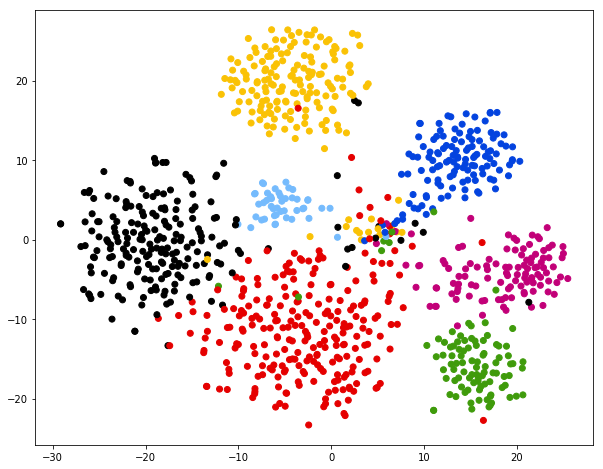

In [27]:
plt.figure(num=None, figsize=(10, 8))  # set the figure size
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=candidate_data['color2'])
plt.show()

In [28]:
import plotly.plotly as py
import plotly.graph_objs as go
#import plotly.offline as pyoff
from plotly import tools

from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.utils import check_random_state

In [29]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

cmap = matplotlib_to_plotly(plt.cm.rainbow, 4)

In [30]:
trace = go.Scatter(x=X_tsne[:, 0], y=X_tsne[:, 1],
                   mode='markers', 
                   marker=dict(color=candidate_data['color'], 
                               colorscale=cmap,
                               showscale=False,
                               line=dict(color='black', width=1)),
                  text=candidate_data['from_name'])
#data.append(trace)
#titles.append("t-SNE (%.2g sec)" % (t1 - t0))

In [35]:
layout=dict(margin=dict(l=10, r=10,
                        t=30, b=10),
           autosize=False,
           width=600,
           height=600)

fig = dict(data=[trace], layout=layout)

In [37]:
py.iplot(fig, filename='tsnePlot2')